# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco.

In [1]:
# TODO: Do we change a little the abstract? Part on the time fresco in particular

## Table of content

In [2]:
# TODO: Make the table of content with the hyperlinks


- Data pre-processing
- Seasonal trend analysis
    - Seasonal influence on beer ratings for low and high ABV beers
    - Seasonal trend in beer ratings at the scale of the US
    - Seasonal trend in beer ratings across the states
- Sentiment analysis
- Semantic analysis

## Data pre-processing 


In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import geopandas as gpd


import plotly.io as pio
pio.renderers.default = "browser"
import plotly.express as px

In [2]:
# Run the preprocessing script
# %run src/scripts/preprocessing.py

#### Loading the data

In [2]:
reviews = pd.read_csv('data/cleaned/reviews.csv.gz', compression='gzip')
ratings = pd.read_csv('data/cleaned/ratings.csv.gz', compression='gzip')
users = pd.read_csv('data/cleaned/users.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/cleaned/beers.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/cleaned/breweries.csv.gz', compression='gzip')

#### Importation of the scripts

In [3]:
import sys
sys.path.append('src')

import scripts.categorization as categ
import scripts.plot as plot
import scripts.statistics as stats
import scripts.sentiment_analysis as sent_ana
import src.scripts.semantic_analysis as sem_ana

## Seasonal trend analysis


To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): **appearance, aroma, taste, mouthfeel, overall and rating**. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{Rating} = 0.06 \cdot \text{Appearance} + 0.24 \cdot \text{Aroma} + 0.4 \cdot \text{Taste} + 0.1 \cdot \text{Mouthfeel} + 0.2 \cdot \text{Overall}
$$

 We focus only on the "rating" metric out of the five others, as similar trends were observed across all of them, and the "rating" metric is derived from the other five scores. A detailed analysis of the individual metrics can be found in the notebook `seasonal_trend_analysis.ipynb`.

In [4]:
# Order the seasons
ratings_top_styles = categ.order_season(ratings)

### Seasonal influence on beer ratings for low and high ABV beers
Beers are also characterized by their **Alcohol By Volume (ABV)**, which was categorized into three groups during the preprocessing and cleaning phase: **low, middle, and high**. We are interested to see whether the ratings of low ABV or high ABV beers are influenced by seasonal changes throughout the year.

In [5]:
mean_ratings = ratings.groupby(['season', 'abv_category'], as_index=False, observed=False)['rating'].mean()

# Separate data for high and low alcohol content
high_abv = mean_ratings[mean_ratings['abv_category'] == 'high']
low_abv = mean_ratings[mean_ratings['abv_category'] == 'low']

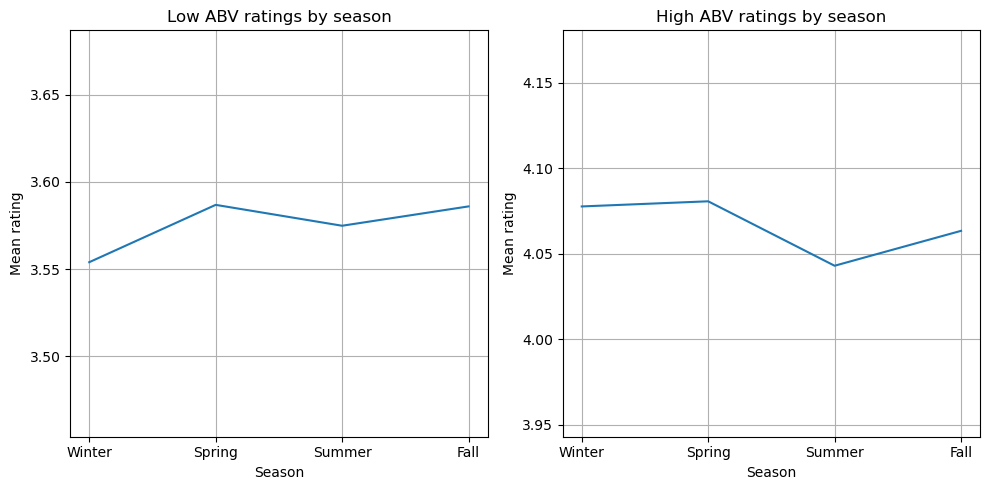

In [6]:
plot.plot_high_low_abv_trends(high_abv, low_abv)

In [6]:
stats.test_seasonal_significance_ABV(ratings, 'low')

Number of ratings per season for 'low' ABV:
season
Summer    375426
Spring    317016
Fall      297901
Winter    289889
Name: count, dtype: int64


/Users/clemencekiehl/Documents/GitHub/ada-2024-project-databrewers/src/scripts/statistics.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_groups = [group['rating'].dropna().values for _, group in filtered_data.groupby('season')]


ANOVA Result: F-statistic = 144.5897, p-value = 0.0000
Significant differences detected among seasons. Performing pairwise Tukey HSD test...

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  Fall Spring   0.0009 0.959 -0.0037  0.0054  False
  Fall Summer  -0.0111   0.0 -0.0154 -0.0067   True
  Fall Winter   -0.032   0.0 -0.0366 -0.0273   True
Spring Summer   -0.012   0.0 -0.0163 -0.0077   True
Spring Winter  -0.0328   0.0 -0.0374 -0.0283   True
Summer Winter  -0.0209   0.0 -0.0253 -0.0165   True
---------------------------------------------------


In [7]:
stats.test_seasonal_significance_ABV(ratings, 'high')

Number of ratings per season for 'high' ABV:
season
Winter    558904
Spring    527384
Summer    484628
Fall      464016
Name: count, dtype: int64


/Users/clemencekiehl/Documents/GitHub/ada-2024-project-databrewers/src/scripts/statistics.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_groups = [group['rating'].dropna().values for _, group in filtered_data.groupby('season')]


ANOVA Result: F-statistic = 484.3607, p-value = 0.0000
Significant differences detected among seasons. Performing pairwise Tukey HSD test...

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0173    0.0  0.0144  0.0201   True
  Fall Summer  -0.0204    0.0 -0.0233 -0.0175   True
  Fall Winter   0.0143    0.0  0.0114  0.0171   True
Spring Summer  -0.0377    0.0 -0.0405 -0.0349   True
Spring Winter   -0.003 0.0248 -0.0057 -0.0003   True
Summer Winter   0.0347    0.0  0.0319  0.0375   True
----------------------------------------------------


ANOVA and Turkey HSD tests revealed that all observed differences in rating between seasons are statistically significant, except for Fall vs. Spring in the low ABV category.

- **Low ABV beers**: These beers are rated highest in Spring, and lowest in Winter (~0.03 difference)

- **High ABV beers**: These beers receive the best ratings during Winter and the lowest in Summer (~0.04 difference)

### Seasonal trend in beer ratings at the scales of the US

From now, we will discuss the seasonal trends when looking at the most rated beers styles. The styles were simplified during preprocessing to regroup beers styles with similar characteristic, bringing the nulber of beer styles from 105 to 45. From these 45 simplified styles, we only kept the one than accounts for at least 2% of the ratings for the following analysis.

In [8]:
# Keep the most rated styles
ratings_top_styles = categ.top_styles(ratings)

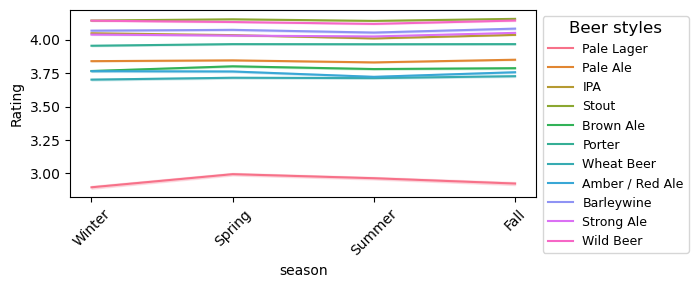

In [10]:
plot.plot(ratings_top_styles, 'season', 'rating', 'style_simp', 'Beer styles')

From the plot above, we can observe that the beers belonging to the **Pale Lager** style show visible variation beetween seasons, especially between winter and spring. For the other styles, the variability is not visible if it exists, especially in the rating score, which contains all other metrics.

In [9]:
anova_season_rating_style = stats.anova_test(ratings_top_styles, rating_column='rating', timescale='season', category='style_simp') 

style_simp: Pale Lager, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0701    0.0  0.0502    0.09   True
  Fall Summer   0.0399    0.0  0.0207  0.0591   True
  Fall Winter   -0.028 0.0019  -0.048  -0.008   True
Spring Summer  -0.0302 0.0001 -0.0487 -0.0118   True
Spring Winter  -0.0981    0.0 -0.1174 -0.0788   True
Summer Winter  -0.0679    0.0 -0.0864 -0.0493   True
----------------------------------------------------
--------------------------------------------------
style_simp: Pale Ale, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -0.0048 0.0489 -0.0095    -0.0 

Analysis of beer ratings across seasons reveals notable seasonal differences for most styles, with some showing no significant differences due to small variations. We consider that even if the test is significant, the difference in between ratings must be at least of 0.01 to be considered a meaningfull difference. All beer styles investigated have more than 100k ratings, we considered that from 0.01 the difference was meaningfull enough. 

- **Higher ratings in warmer months (spring/summer)**:  
  - **Pale Lager** ratings are higher in spring and summer than in fall and winter, with spring ratings beating winter ratings by nearly 0.1 points and summer ratings outperforming fall ratings by 0.04 points. However, fall and winter ratings differ by only 0.03 points, suggesting minimal practical differences compared to the other variations of the style.
  - **Pale Ale** shows a preference for summer, with ratings 0.02 points higher than fall, while winter ratings are 0.01 points lower than fall. The differences between fall and spring are negligible, only 0.005 points.
  - The **IPA** ratings show a clear preference for summer, outperforming fall by 0.027 points and winter by 0.04 points. Conversely, fall and spring ratings show no significant difference (0.002 points). 
  - **Wild Beer** ratings favor summer, with ratings 0.025 points higher than fall, while winter ratings are nearly equal to fall (0.0011 point difference). 
  - **Amber/Red Ale** ratings are significantly higher in summer, exceeding fall by 0.0344 points and winter by 0.0425 points, while other seasonal differences are negligible.
  - For **Brown Ale**, ratings peak in the spring, outperforming the fall by 0.014 points and winter by 0.035 points. Summer and fall ratings are nearly equal, differing by only 0.006 points. 

- **Higher ratings in colder months (fall/winter)**:  
  - Ratings for **Wheat Beer** favor winter, with ratings 0.026 points higher than fall and 0.012 points lower than summer. There are no differences between spring and summer (0.002 points).
  - For **Barleywine**, winter ratings generally outperform both fall and summer, with winter ratings 0.015 points higher than fall and 0.014 points higher than summer. Summer ratings are the lowest, with a difference of 0.03 points compared to fall and 0.02 points compared to spring. Spring and winter do not show a significant difference.
  - **Stong Ale** receives its highest ratings in the fall, with the largest difference between the spring and summer months being 0.2 and 0.26 points, respectively. Winter ratings are also slightly lower than in the fall months, with a difference of 0.13 points. 

- **Consistent ratings across seasons**:  
  - For **Stouts**, winter ratings are slightly higher than fall and spring by 0.013 and 0.009 points, respectively, but no difference is observed between fall and spring or summer and winter. Since the difference is minimal, we consider it negligible.
  - **Porters** shows slightly higher ratings in winter, trailing fall by 0.012 points. The differences between fall, spring, and summer are negligible, all less than 0.01 points. Again, the difference is so small that we consider it negligible.

In summary, the following trends can be observed:

- **Warmer months**:  
  Lighter styles such as **Pale Lager**, **Pale Ale**, **IPA**, **Wild Beer**, **Amber/Red Ale**, **Brown Ale** and **Strong Ale** perform better in the spring and summer. These styles score higher in the warmer months, consistent with the preference for lighter, more refreshing beers during this time. **Pale Lager** and **IPA** show the most improvement in summer, while **Amber/Red Ale** has the highest ratings in summer compared to other seasons. 

- **Colder months**:  
  Richer and heavier styles such as **Wheat Beer**, **Barleywine**, **Strong Ale** have higher ratings in winter and fall. These beers, known for their fuller body and warming qualities, are more popular in the colder months. **Barleywine** and **Wheat Beer** are especially popular in winter, while **Strong Ale** has its highest ratings in fall, outperforming both spring and summer.

- **Minimal or No Seasonal Variation**:  
  **Stouts** and **Porters** show very small differences across seasons. The differences are minimal and do not reach the threshold of practical significance, indicating that these styles have consistent appeal throughout the year regardless of season.

### Seasonal trend in beer ratings across the states

Since we did not observe a significant difference in beer style preferences across seasons at the scale of the United States, we are interested to see whether there will be more pronounced changes at the state level.

First, the states were divided into three different categories:
- **Northeast** (e.g. New-York)
- **South** (e.g. Texas)
- **West** (e.g. California)
- **Midwest** (e.g. Minnesota)

We first hypothesize that, since the four regions experience varying weather conditions throughout the seasons, this may impact their ratings. However, analysis conducted in the `seasonal_trend_analysis.ipynb` notebook shows that the trends in ratings for the regions individually were not significantly different from the overall trend for the United States, particularly for the low and high ABV categories, as shown below:

/Users/clemencekiehl/Documents/GitHub/ada-2024-project-databrewers/src/scripts/plot.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['season', 'region', 'abv_category'])[metric].mean().reset_index()


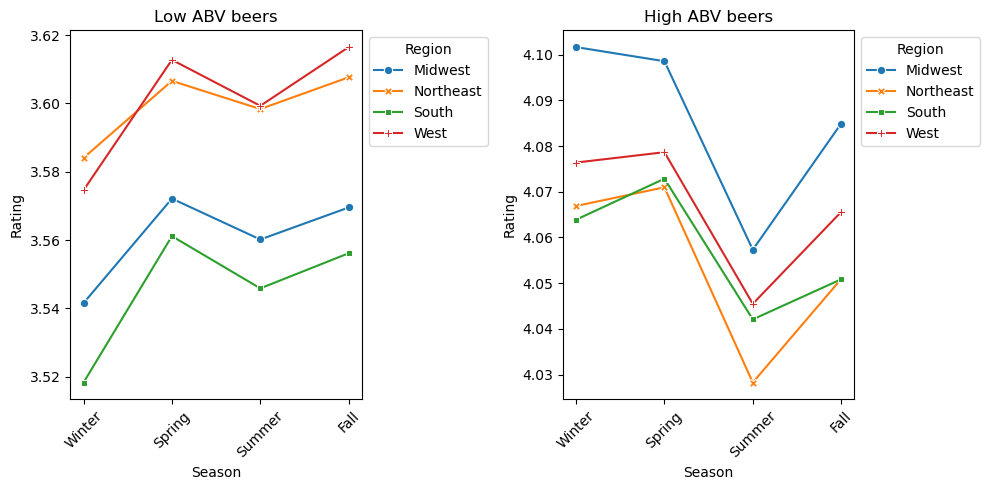

In [10]:
plot.plot_abv_seasonal_trends(ratings, "rating")

We are then interested in exploring the **preferred beer styles** across states and seasons. By doing so, we may be able to observe more pronounced changes and get more insights on how the season influences the appreciation of different beer styles. To get the preferred beer styles by season and state, we take the beer style that score the highest ratings on the "rating" metrics. 

In [10]:
# Strip the state names
ratings['states'] = ratings['states'].str.strip()

# Regroup reviews by states, season and style
state_season_style = (ratings.groupby(['states', 'season', 'style_simp'], observed=False)
                          .agg({'rating': 'mean'})
                          .reset_index())

# Keep only the highest rated style for each state-season
highest_rated_style = (
        state_season_style.loc[state_season_style.groupby(['states', 'season'], observed=False)['rating'].idxmax()]
        .reset_index(drop=True)
    )

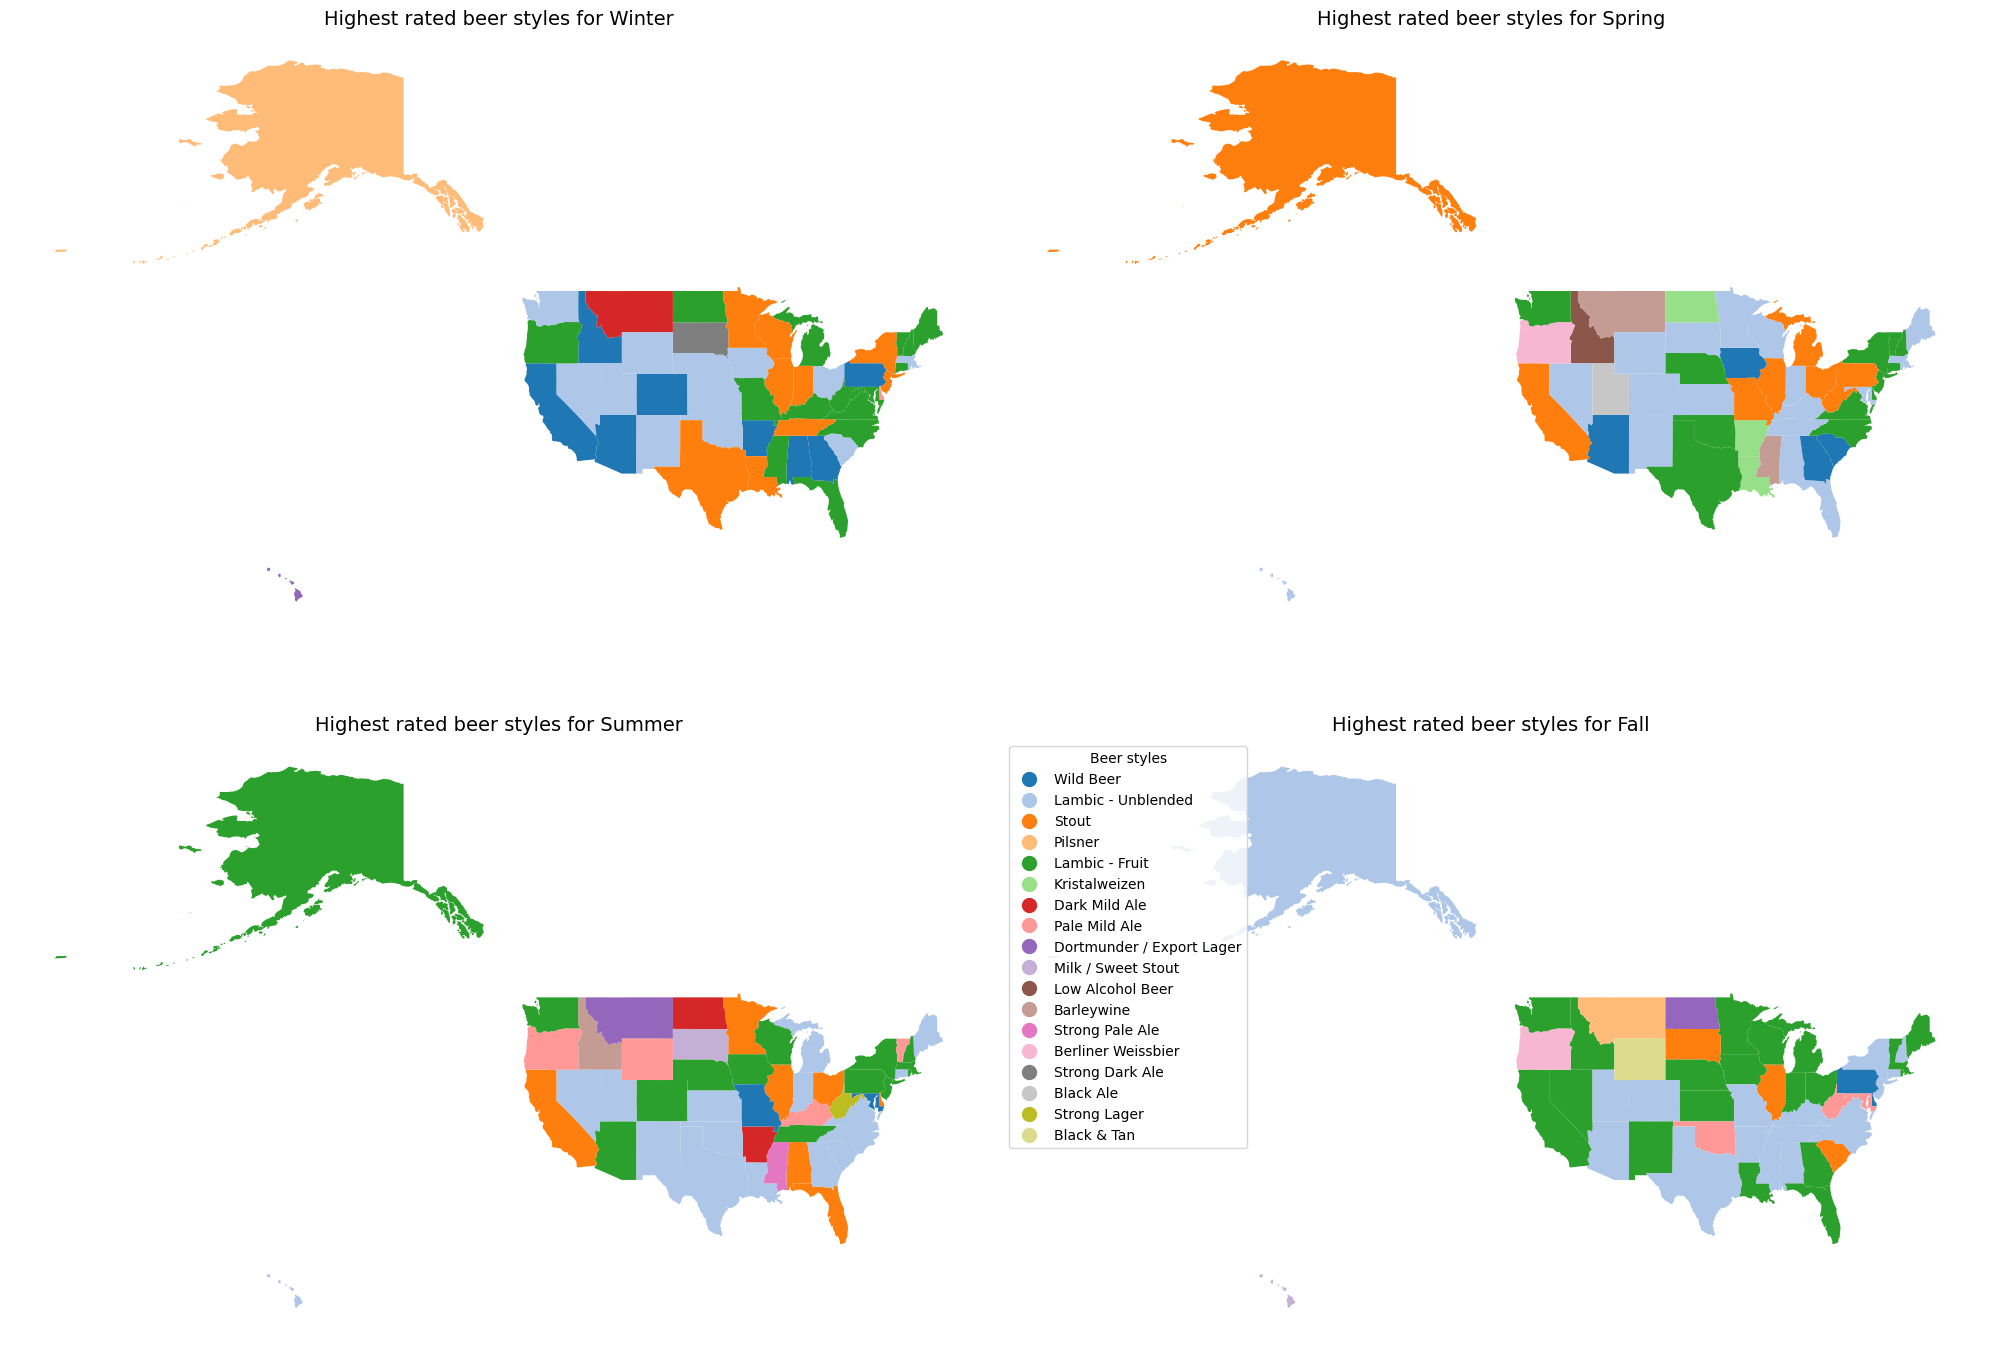

In [12]:
plot.plot_highest_rated_styles_by_season(highest_rated_style)

We can observe that the preferred beer styles are not the same in every state, and that they change with the seasons. If we divide the map of the USA in four regions (e.g. **West, South, Midwest, Northeast**), we get the following key observations:

- **Winter**: In the _West_, Wild beer and Lambic-Unblended are favored, while in Montana, Dark Mild Ale stands out. The _South_ prefers Stouts and Wild beer, while the _Midwest_ and _Northeast_ favor Dark Mild Ale and Stout, or Lambic-Fruit in the Northeast.

- **Spring**: The _West_ leans towards Pale Mild Ale, low alcohol beer and Lambic-Fruit. The _South_ and _Northeast_ also lean towards Lambic-Fruit, as well as Kristalweizen for the _South_. The _Midwest_ also appreciates Kristalweizen, and we can see a shift, notably from Stout to Lambic-Unblended. 

- **Summer**: The _West_ continues to favor Pale Mild Ale and Lambic-Fruit. The _South_ leans towards Lambic-Unblend, while the _Northeast_ stays consistent with Lambic-Fruit. The _Midwest_ prefers Lambic-Fruit and Milk/Sweet Stout. 

- **Fall**: The _West_ still appreciates Lambic-Fruit, but there is a move towards more Strong Pale Ale, particularly in Oregon. The _South_ still prefers Lambic-Unblended, while some states are moving towards Pale Mild Ale. The _Midwest_ remains consistent with Lambic-Fruit, while a certain preference for Stout is beginning to emerge. The _Northeast_ leans towards Lambic-Unblended and Wild beer. 

Thus, we can see that as the seasons transition from **warmer to colder**, there is a shift in preferences from **fruitier and lighter** beer styles (e.g. Lambic-Fruit, Pale Mild Ale) to **stronger** beer styles (e.g. Stout, Dark Mild Ale).



## Sentiment analysis

In this section we look at the words used in the review to try to determine the ones that are associated to positive reviews and the ones associated to negative ones.

- We define that a beer is **positively graded** if the rating grade strictly bigger than 4/5.
- We define that a beer is **negatively graded** if the rating grade strictly less than 3/5.

This will allow use to determine the aspects of a beer that are **liked or disliked** by reviewers. This way we will be able to better understand the consumer preferences.

In [11]:
# The sentiment analysis script are downloaded as sent_ana

# We download the stopwords to use them in the sentiment analysis
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clemencekiehl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# We begin by cleaning the reviews 
reviews_clean = sent_ana.clean_data(reviews)

# Separate the reviews into two groups: those with a rating higher than 4 and those with a rating lower than 3
reviews_high = reviews_clean[reviews_clean['rating'] > 4]
reviews_low = reviews_clean[reviews_clean['rating'] < 3]

# Tokenize the reviews
bigrams_high, bigrams_low = sent_ana.get_words(reviews_high, reviews_low)

# Count bigram frequencies for each group
bigram_freq_high = Counter(bigrams_high)
bigram_freq_low = Counter(bigrams_low)

/Users/clemencekiehl/Documents/GitHub/ada-2024-project-databrewers/src/scripts/sentiment_analysis.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clean['cleaned_tokens'] = reviews_clean['text'].apply(preprocess_text)
Processing Low Ratings: 100%|██████████| 156033/156033 [00:15<00:00, 10139.87it/s]


To make it easier to visualise, we use Word Clouds. This way we can easily see the pair of words that are the most used, both for high and low ratings, and compare the potential differences between the two.

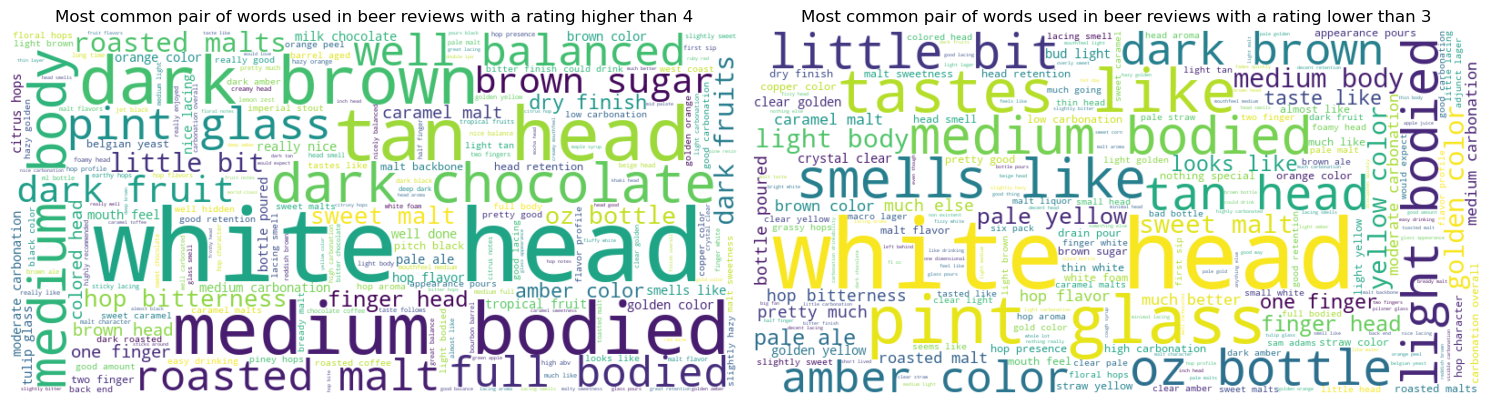

In [16]:
# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_low)

# We plot word clouds for both groups
sent_ana.plot_word_clouds(wordcloud_high, wordcloud_low)

Now that we know the pair of words that are the most used in reviews with **high ratings** (>4/5) and **low ratings** (<3/5), we can see that some pair of words seem specific to well rated beers, and some seem specific to poorly rated beers.

We further investigate this to extract pair of words used only positively and pair of words used only negatively. This will allow us to determine the user preferences and potentially what makes a beer enjoyable or not.

In [13]:
# We compare the most common bigrams in both groups
df_comparison = sent_ana.compare_high_low(bigram_freq_high, bigram_freq_low, reviews_high, reviews_low)

# We plot the comparison
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
28      white head                20.532803               23.064993
25        tan head                 9.291707                4.183089
15   medium bodied                 8.923919                5.115585
2       dark brown                 7.385701                3.972237
16     medium body                 6.685652                3.762025
20      pint glass                 6.139436                8.473848
8      full bodied                 5.657099                     NaN
27   well balanced                 5.595725                     NaN
3   dark chocolate                 5.502469                     NaN
21    roasted malt                 4.690034                     NaN
4       dark fruit                 4.294007                     NaN
1      brown sugar                 4.171487                     NaN
17       oz bottle                 4.057735                4.561856
13      little bit                 3.998410     

Now that we have the 20 most common pair of words for both positive and negative reviews, as well as the percentage of reviews containing it, we can draw new conclusions. If a pair of words appear only in positive (resp. negative) reviews, and not in the negative (resp. positive) reviews, we can deduct that it is a rather positive (resp. negative) pair of words.

Some pair of words seem to be **neutral** as they appear in both positive and negative reviews. It could also simply mean that we need more context to understand whether they are associated to positive or negative feelings in the reviews. Among these, we can find the following pairs of words:
- white head 
- tan head
- medium bodied / medium body

There are also some pairs of words that are not really relevant to our analysis. For example the following pairs of words do not convey information on the caracteristics of a beer that reviewers like or dislike:
- pint glass
- oz bottle
- smells like / tastes like

However, we can also easily see that some pairs of words are used only in a positive or negative context.

We have that the following pairs of words only appear in **positive reviews**:
- full bodied
- dark chocolate 
- dark fruit / dark fruits
- roasted malts

While the following pairs of words only appear in **negative reviews**: 
- light bodied / light body
- amber color
- yellow color / pale yellow

This analysis highlights the fact that reviewers seem to prefer **full bodied** beers to **light bodied** ones. **Medium bodied** beers are cited in both positive and negative reviews.
Consumers also seem to appreciate specific flavors and aromes as **dark chocolate**, **dark fruits**.

## Semantic analysis

In [14]:
clean_reviews = sem_ana.get_cleaned_reviews(reviews)

100%|██████████| 2048878/2048878 [23:16<00:00, 1466.71it/s] 
/Users/clemencekiehl/Documents/GitHub/ada-2024-project-databrewers/src/scripts/semantic_analysis.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clean['cleaned_tokens'] = reviews_clean ['text'].progress_apply(preprocess_text)


top_20_words,word_freq = sem_ana.top_n_words(clean_reviews, 20)

In [38]:
display(clean_reviews.head())

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,country,states,region,style_simp,abv_category,year,month,day,season,cleaned_tokens
0,4.5,3.25,2.75,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),2015-08-20 10:00:00,3.00,3.25,...,United States,Washington,West,Pale Lager,low,2015,8,20,Summer,"[from, a, bottle, pours, a, piss, yellow, colo..."
1,4.5,3.00,3.50,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,2009-02-20 11:00:00,3.50,3.50,...,United States,New York,Northeast,Pale Ale,low,2009,2,20,Winter,"[pours, pale, copper, with, a, thin, head, tha..."
2,4.8,4.25,4.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-02-13 11:00:00,3.75,3.25,...,United States,North Carolina,South,Pale Ale,low,2013,2,13,Winter,"[this, was, a, 12, oz, bottle, poured, into, a..."
3,4.8,4.00,3.75,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-01-09 11:00:00,3.75,3.50,...,United States,New York,Northeast,Pale Ale,low,2013,1,9,Winter,"[poured, from, a, 12, ounce, bottle, into, a, ..."
4,4.8,3.00,3.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2012-11-17 11:00:00,2.50,2.50,...,United States,Illinois,Midwest,Pale Ale,low,2012,11,17,Fall,"[beer, poured, from, bottle, into, a, nonic, s..."


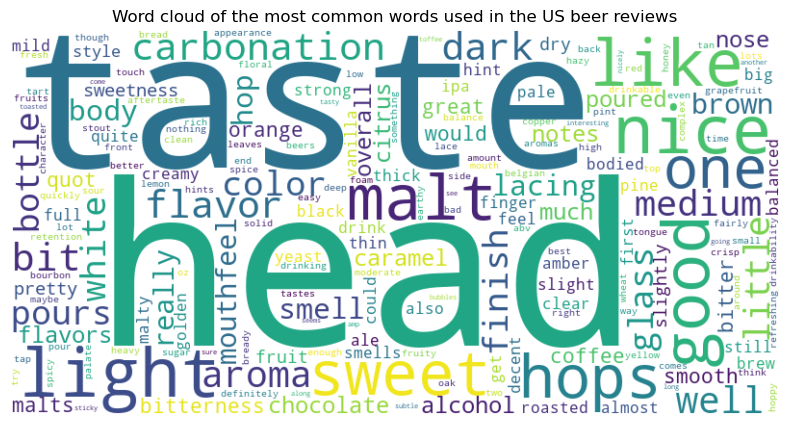

In [21]:
sem_ana.gen_wordcloud(word_freq)

Classifying words...


Word Classification Progress: 100%|██████████| 5000/5000 [00:00<00:00, 678689.97it/s]


Word classification completed.
Number of positive words among the top 5000 words: 419
Number of negative words among the top 5000 words: 256


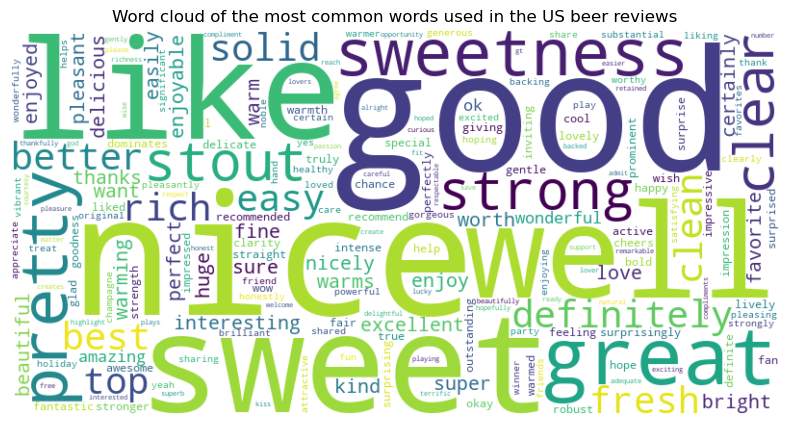

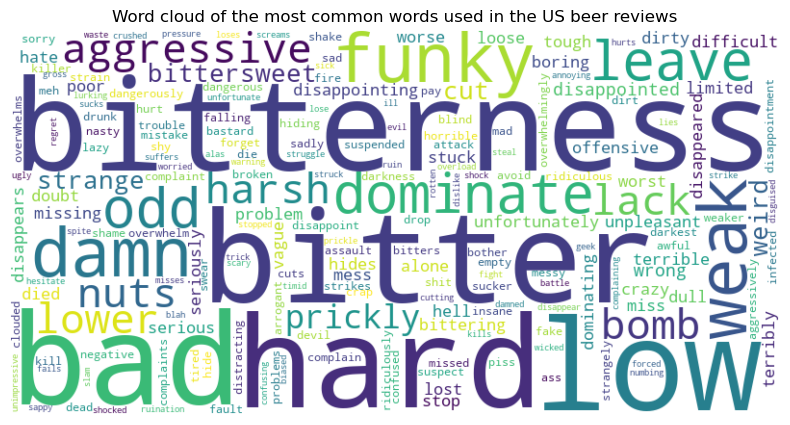

In [22]:
sem_ana.sentiment_analysis(word_freq)

In [28]:
sem_ana.analyse_flavours(clean_reviews)

100%|██████████| 644596/644596 [00:04<00:00, 142280.35it/s]


KeyError: "None of [Index(['hoppy', 'malty', 'fruity', 'spicy', 'citrus', 'sweet', 'bitter',\n       'sour', 'tart', 'crisp'],\n      dtype='object')] are in the [columns]"

Now that we did a general sementic analysis on reviews, we will perform a sementic comparaison on the season reviews, keeping only the highly rated ones. To do so, we categorize the reviews according to the season when they were written.

In [15]:
clean_positive_reviews = sem_ana.filter_positive_reviews(clean_reviews)

In [39]:
display(clean_positive_reviews.head())

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,country,states,region,style_simp,abv_category,year,month,day,season,cleaned_tokens
10,4.8,4.0,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2011-11-11 11:00:00,4.0,4.0,...,United States,Georgia,South,Pale Ale,low,2011,11,11,Fall,"[poured, into, a, jail, house, brewery, tumble..."
19,4.8,4.0,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2011-05-16 10:00:00,4.0,4.5,...,United States,Georgia,South,Pale Ale,low,2011,5,16,Spring,"[foamy, two, finger, head, with, lace, that, r..."
49,4.8,3.5,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-03-29 10:00:00,4.0,4.0,...,United States,New Jersey,Northeast,Pale Ale,low,2010,3,29,Spring,"[pours, a, dark, amber, mahogany, color, with,..."
58,6.0,4.0,4.0,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,2011-08-06 10:00:00,4.0,4.0,...,United States,Mississippi,South,Pale Ale,middle,2011,8,6,Summer,"[poured, into, a, sam, adams, perfect, pint, g..."
64,4.2,4.5,4.0,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,2012-04-28 10:00:00,4.0,4.0,...,United States,North Carolina,South,Bitter,low,2012,4,28,Spring,"[appearance, a, beautiful, pour, with, a, mass..."


In [16]:
winter_reviews = clean_positive_reviews[reviews['season'] == 'Winter']
spring_reviews = clean_positive_reviews[reviews['season'] == 'Spring']
summer_reviews = clean_positive_reviews[reviews['season'] == 'Summer']
autumn_reviews = clean_positive_reviews[reviews['season'] == 'Fall']

season_reviews = {
    "Winter": winter_reviews,
    "Spring": spring_reviews,
    "Summer": summer_reviews,
    "Autumn": autumn_reviews
}



/var/folders/jq/hm7ltmp94_s1d6cb653mrr4w0000gn/T/ipykernel_10944/4075846754.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  winter_reviews = clean_positive_reviews[reviews['season'] == 'Winter']
/var/folders/jq/hm7ltmp94_s1d6cb653mrr4w0000gn/T/ipykernel_10944/4075846754.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spring_reviews = clean_positive_reviews[reviews['season'] == 'Spring']
/var/folders/jq/hm7ltmp94_s1d6cb653mrr4w0000gn/T/ipykernel_10944/4075846754.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  summer_reviews = clean_positive_reviews[reviews['season'] == 'Summer']
/var/folders/jq/hm7ltmp94_s1d6cb653mrr4w0000gn/T/ipykernel_10944/4075846754.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  autumn_reviews = clean_positive_reviews[reviews['season'] == 'Fall']


In [17]:
# Create the different evaluation/criteria groups

aroma_groups = {
    'Malt': ['malt', 'malty', 'darker malt', 'roasty', 'roasted', 'smoke', 'smoky', 'toasty', 'nutty', 'nut', 'chocolate', 'toffee', 'caramel', 'biscuit', 'bread'],
    'Fruity': ['fruit', 'fruity', 'fruits', 'citrus', 'grapefruit'],
    'Spicy': ['spicy', 'spice', 'cinnamon'],
    'Herbal': ['herbal', 'herbs', 'grass', 'grassy', 'hay', 'floral', 'florals', 'flower', 'flowers', 'leafy']
}

palate_groups = {
    'Sweet': ['sweet', 'sugary'],
    'Bitter': ['bitter'],
    'Sour': ['sour', 'acidic'],
    'Spicy': ['spicy', 'spice', 'cinnamon'],
}


mouthfeel_groups = {
    'Creamy': ['creamy', 'cream'],
    'Smooth': ['smooth', 'smoothness'],
    'Dry': ['dry', 'dryness'],
    'Tart': ['tart'],
    'Flat': ['flat'],
    'Thin': ['thin'],
    'Rich': ['rich']

}

taste_groups = {
    'Malt': ['malt', 'malty', 'darker malt', 'roasty', 'roasted', 'smoke', 'smoky', 'toasty', 'nutty', 'nut', 'chocolate', 'toffee', 'caramel', 'biscuit', 'bread'],
    'Fruity': ['fruit', 'fruity', 'fruits', 'citrus', 'grapefruit'],
    'Spicy': ['spicy', 'spice', 'cinnamon'],
    'Herbal': ['herbal', 'herbs', 'grass', 'grassy', 'hay', 'floral', 'florals', 'flower', 'flowers', 'leafy'],
    'Sweet': ['sweet', 'sugary'],
    'Bitter': ['bitter'],
    'Sour': ['sour', 'acidic'],
    'Spicy': ['spicy', 'spice', 'cinnamon']
}


In [93]:
def visualize_word_occurrences(word_counts, word):
    """
    Visualizes the occurrences of a specific word for each time period.

    Args:
    - word_counts (dict): Dictionary where keys are time periods and values are the count of the word.
    - word (str): The word being analyzed.
    """


    time_periods = list(word_counts.keys())
    counts = list(word_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(time_periods, counts, color='skyblue')
    plt.xlabel('Time period')
    plt.ylabel(f'Occurrences of "{word.capitalize()}" related terms')
    plt.title(f'Occurrences of terms related to "{word.capitalize()}" per time period')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def word_analysis_by_time_period(reviews_dict, word):
    """
    Analyzes the occurrences of a specific word in reviews grouped by time periods.
    
    Args:
    - reviews_dict (dict): A dictionary where keys are time periods (e.g., seasons) and 
      values are DataFrames containing reviews.
    - word (str): The word to analyze.
    
    Returns:
    - dict: A dictionary with time periods as keys and word occurrence counts as values.
    """
    word_counts = {}

    for time_period, reviews in reviews_dict.items():
        word_counts[time_period] = reviews['cleaned_tokens'].apply(lambda tokens: tokens.count(word)).sum()
    
    return word_counts





#def analyze_and_visualize_group_occurrences(word_group, season_reviews):
    """
    Analyzes and visualizes the occurrences of words within a specific group across seasons.
    
    Args:
    - word_group (dict): A dictionary where keys are group names and values are lists of words.
    - season_reviews (dict): A dictionary where keys are seasons and values are DataFrames of reviews.
    """
    for group_name, word_list in word_group.items():
        # Initialize a dictionary to store combined counts for each season
        combined_counts = {}

        # Iterate through the words in the group and calculate their occurrences
        for word in word_list:
           
            word_counts = word_analysis_by_time_period(season_reviews, word=word)
            for season, count in word_counts.items():
                combined_counts[season] = combined_counts.get(season, 0) + count

        # Visualize the combined occurrences for the group
        visualize_word_occurrences(combined_counts, word=group_name)



def analyze_and_visualize_group_occurrences(groups, reviews_by_season):
    # Initialize the subplot grid
    num_groups = len(groups)
    fig, axes = plt.subplots(nrows=num_groups, ncols=1, figsize=(10, 5 * num_groups))
    fig.tight_layout(pad=5.0)
    
    if num_groups == 1:  
        axes = [axes]

    # Iterate through the groups and visualize their occurrences
    for idx, (group_name, word_list) in enumerate(groups.items()):
        group_occurrences = {}
        
        # Analyze occurrences for each word in the group
        for word in word_list:
            word_counts = word_analysis_by_time_period(reviews_by_season, word=word)
            for season, count in word_counts.items():
                group_occurrences[season] = group_occurrences.get(season, 0) + count
        
        # Normalize occurrences to percentages
        total_reviews_by_season = {
            season: len(reviews) for season, reviews in reviews_by_season.items()
        }
        group_percentages = {
            season: (group_occurrences.get(season, 0) / total_reviews_by_season[season]) * 100
            if total_reviews_by_season[season] > 0 else 0
            for season in reviews_by_season
        }
        
        # Plot the group's data as a bar chart
        ax = axes[idx]
        ax.bar(group_percentages.keys(), group_percentages.values(), color='skyblue')
        ax.set_title(f"Percentage of positive reviews mentioning {group_name} related terms by season")
        ax.set_ylabel("Percentage of positive reviews mentioning {group_name} related terms")
        ax.set_xlabel("Season")
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()




##### Aroma preferences

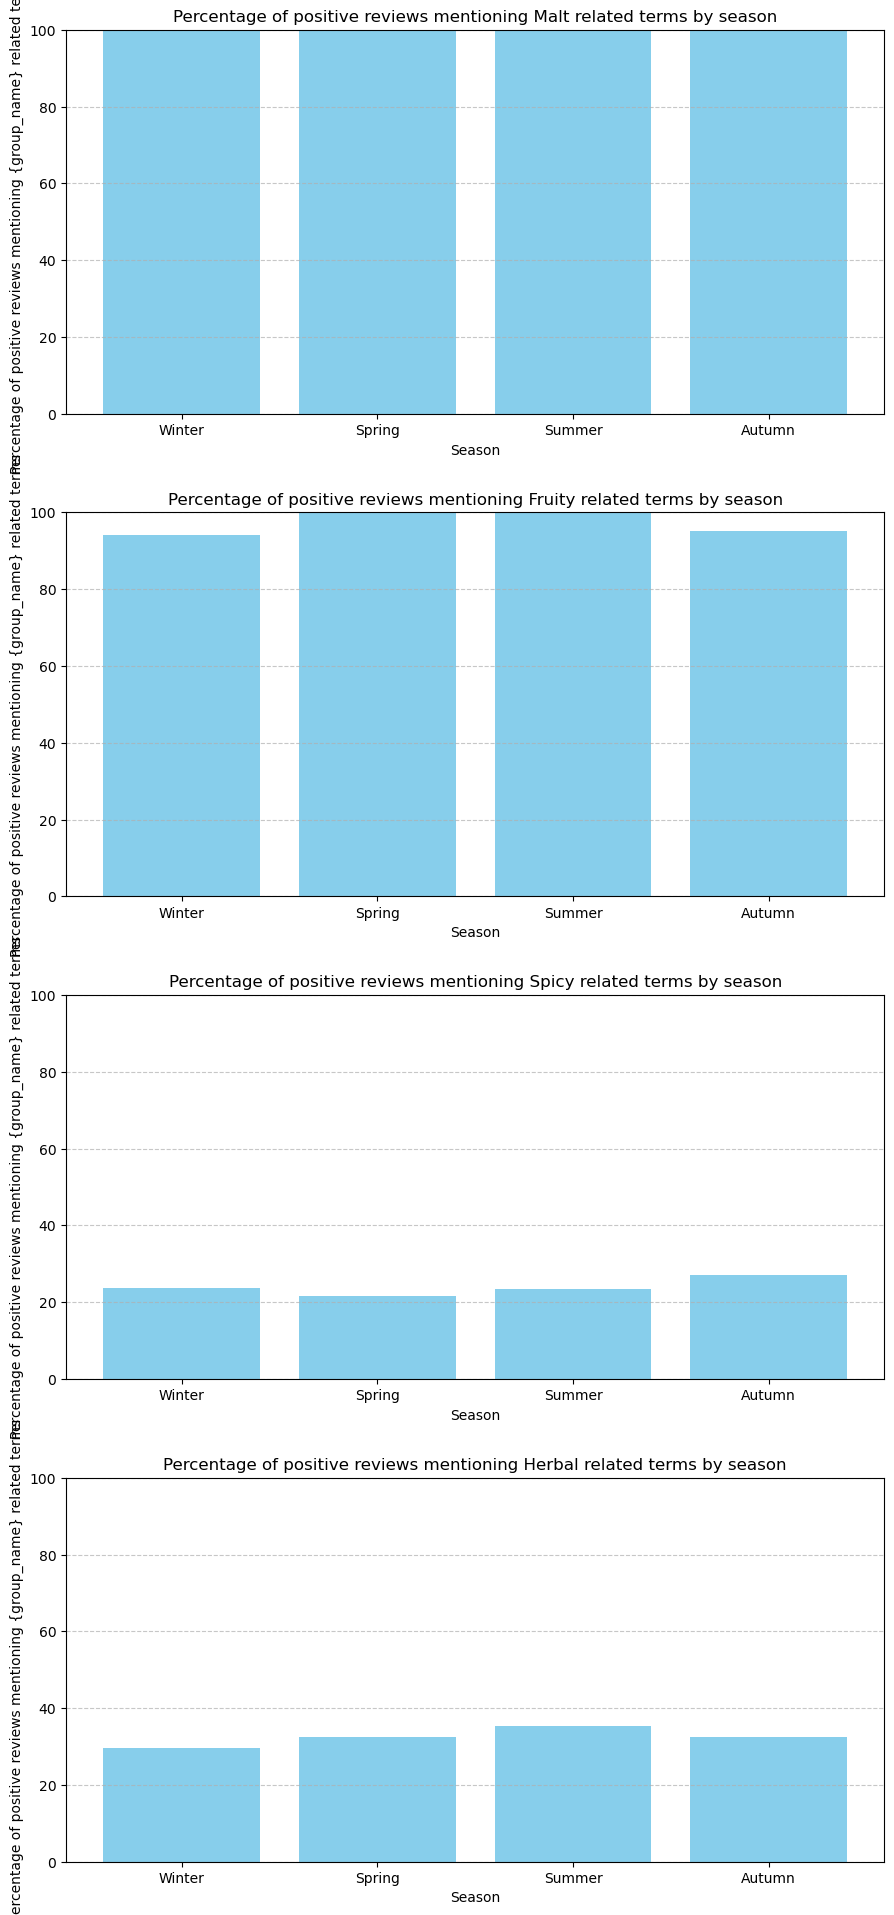

In [94]:
analyze_and_visualize_group_occurrences(aroma_groups, season_reviews)


Concerning aroma peferences, we can see a higher number of positive reviews mentioning fruit and herbal aromas during summer. On the contrary, spicyness is more represented in positive autumn reviews.

##### Mouthfeel preferences

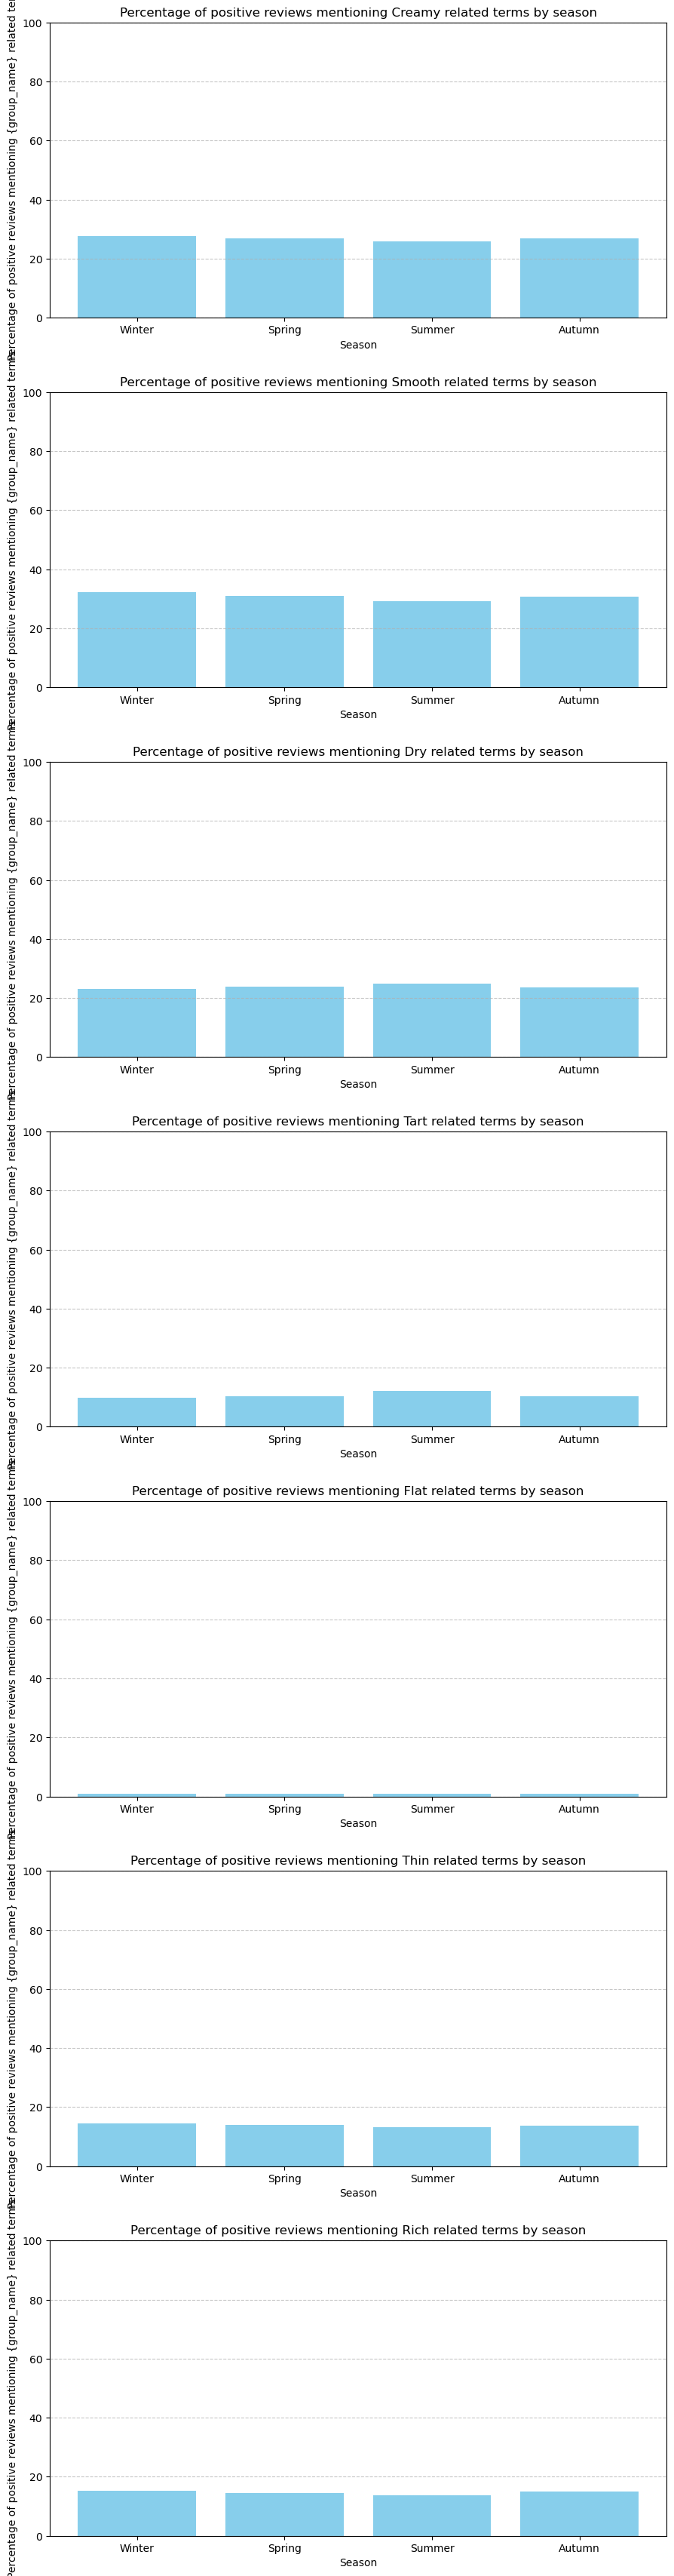

In [95]:
analyze_and_visualize_group_occurrences(mouthfeel_groups, season_reviews)


Concerning Mouthfeel preferences, we can't see a stricking difference among seasons. However, we can wee a slight difference for "rich" related terms, that are less represented in positive summer reviews. On the side, "tart" related reviews are a bit more represented during summer.

##### Palate preferences

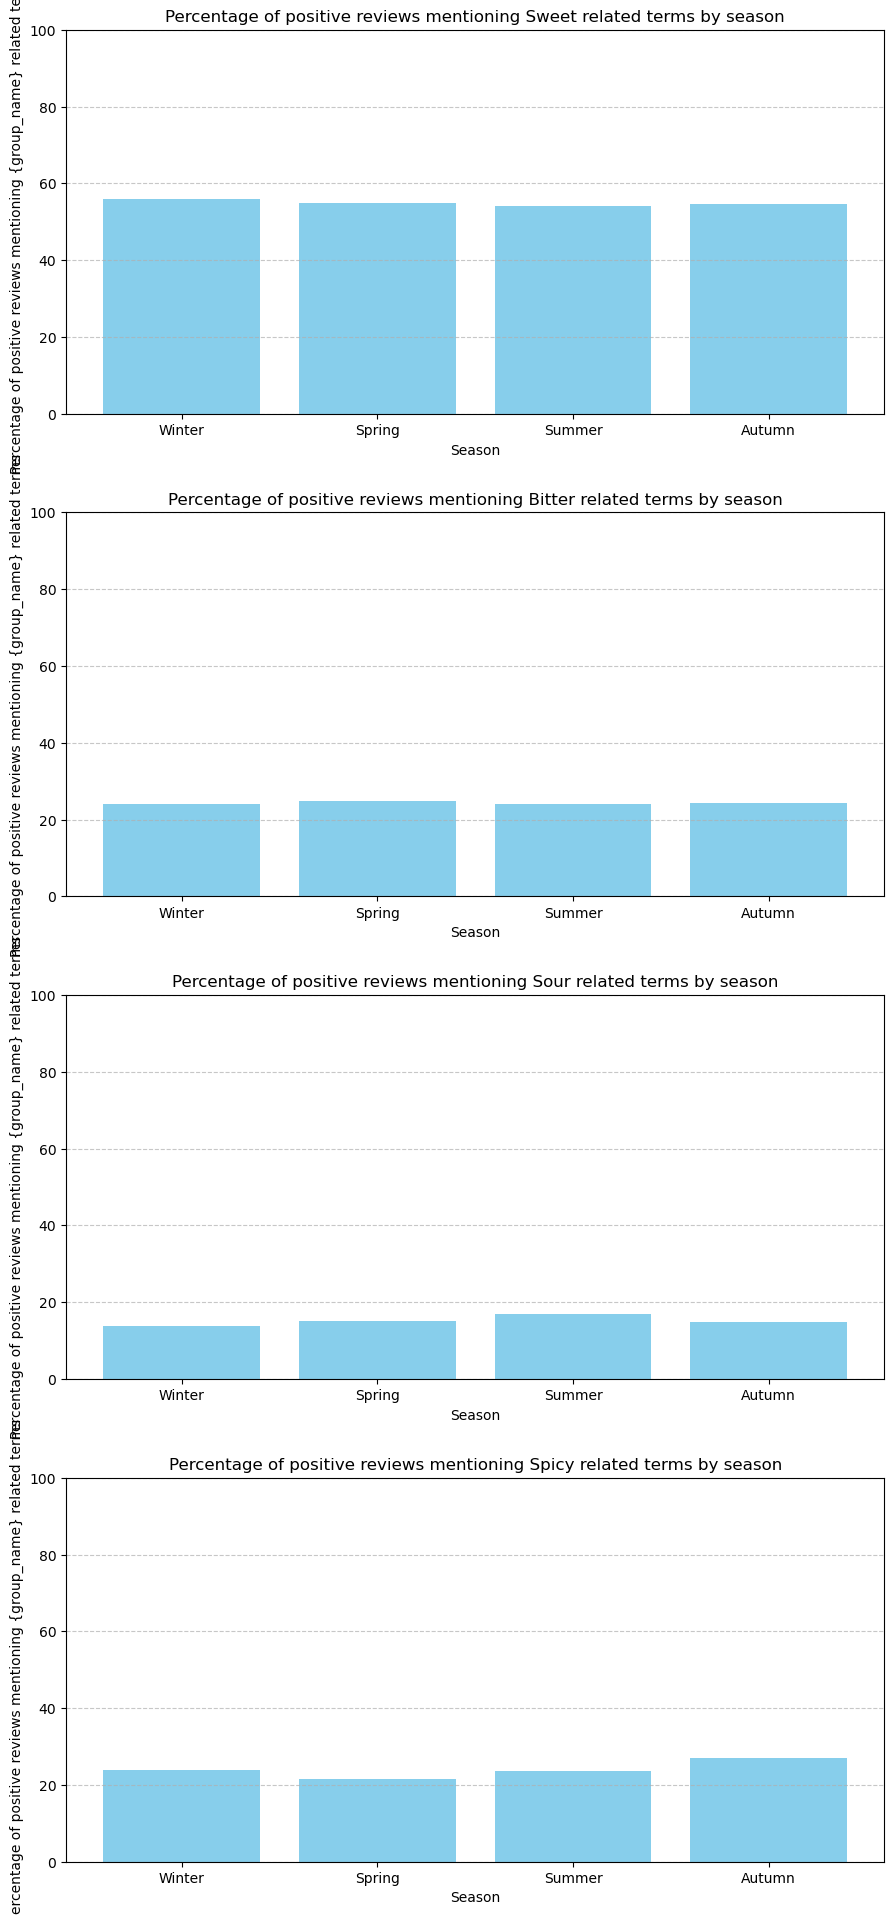

In [96]:
analyze_and_visualize_group_occurrences(palate_groups, season_reviews)


For palate related words, we can deduce that spicyness is more represented in positive autumn reviews, whereas "sour" related terms are more represented during summer.

To better visualize this sementic comparaison of those 4 criterias on the season reviews, we decided to create a treemap for each season and criteria (moutfeel, aroma, etc.)

In [78]:
# Function to preprocess and extract word counts for each criteria/evaluation group
def preprocess_and_count(reviews, related_words):
    group_word_counts = {group: 0 for group in related_words.keys()} 

    # Iterate through reviews
    for review in reviews['cleaned_tokens']:
        for group, words_list in related_words.items():
            for word in review:
                if word in words_list:
                    group_word_counts[group] += 1

    return group_word_counts



def create_treemap(word_counts, category_name, season):
    """
    Creates a treemap based on word counts for a specific category.

    Parameters:
    - word_counts (dict): A dictionary with group names as keys and word counts as values.
    - category_name (str): The name of the category (e.g., 'Taste', 'Mouthfeel').
    - season (str): The season for which the reviews are processed (e.g., 'Winter').

    Returns:
    - Plotly Figure: The generated treemap plot.
    """
    # We convert the word counts into a format suitable for a treemap
    treemap_data = [{"Category": category_name, "Subcategory": group, "Count": count}
                    for group, count in word_counts.items()]

    # We define the title including the season
    title = f"Occurrences of {category_name} related terms in positive {season} reviews"

    # Create the treemap using Plotly
    fig = px.treemap(
        treemap_data, 
        path=["Category", "Subcategory"],  # Path defines the hierarchy
        values="Count",  # The values to size the tiles
        title=title
    )

    fig.show()







In [81]:
# List of all the group names you'd like to generate treemaps for
group_names = ['taste', 'mouthfeel', 'aroma', 'palate']


group_data_dict = {
    'taste': taste_groups,
    'mouthfeel': mouthfeel_groups,
    'aroma': aroma_groups,
    'palate': palate_groups
}


seasons = ['Winter', 'Spring', 'Summer', 'Autumn']  


for season in seasons:
    for group_name in group_names:
        word_counts = preprocess_and_count(season_reviews[season], group_data_dict[group_name])
        create_treemap(word_counts, group_name, season)


In [82]:


# Function to preprocess and extract word counts for each group, then calculate percentages
def preprocess_and_count(reviews, related_words):
    group_word_counts = {group: 0 for group in related_words.keys()}  # Initialize word count for each group

    # Calculate the total number of reviews
    total_reviews = len(reviews)

    # Iterate through reviews
    for review in reviews['cleaned_tokens']:
        for group, words_list in related_words.items():
            for word in review:
                if word in words_list:
                    group_word_counts[group] += 1

    # Calculate the percentage for each group based on the total number of reviews
    group_percentages = {group: (count / total_reviews) * 100 for group, count in group_word_counts.items()}

    return group_percentages


def create_treemap(word_percentages, category_name, season):
    """
    Creates a treemap based on word percentages for a specific category.

    Parameters:
    - word_percentages (dict): A dictionary with group names as keys and word percentages as values.
    - category_name (str): The name of the category (e.g., 'Taste', 'Mouthfeel').
    - season (str): The season for which the reviews are processed (e.g., 'Winter').

    Returns:
    - Plotly Figure: The generated treemap plot.
    """
    # Convert the word percentages into a format suitable for a treemap
    treemap_data = [{"Category": category_name, "Subcategory": group, "Percentage": percentage}
                    for group, percentage in word_percentages.items()]

    # Define the title including the season
    title = f"Occurrences of {category_name} related terms in positive {season} reviews (Percentage)"

    # Create the treemap using Plotly
    fig = px.treemap(
        treemap_data, 
        path=["Category", "Subcategory"],  # Path defines the hierarchy
        values="Percentage",  # The values to size the tiles (percentage of occurrences)
        title=title
    )

    fig.show()



In [83]:

group_names = ['taste', 'mouthfeel', 'aroma', 'palate']

# Dictionary of groups and corresponding group data (e.g., 'taste_groups', 'mouthfeel_groups', etc.)
group_data_dict = {
    'taste': taste_groups,
    'mouthfeel': mouthfeel_groups,
    'aroma': aroma_groups,
    'palate': palate_groups
}

# List of seasons
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']  


for season in seasons:
    for group_name in group_names:
        word_counts = preprocess_and_count(season_reviews[season], group_data_dict[group_name])
        create_treemap(word_counts, group_name, season)